In [44]:
!pip install torch torchvision numpy opencv-python matplotlib pandas


In [45]:
import os
import re
import torch
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from matplotlib import pyplot as plt


In [46]:
import cv2
from glob import glob

image_path = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/"
images = glob(image_path + "*.png")
len(images)

7470

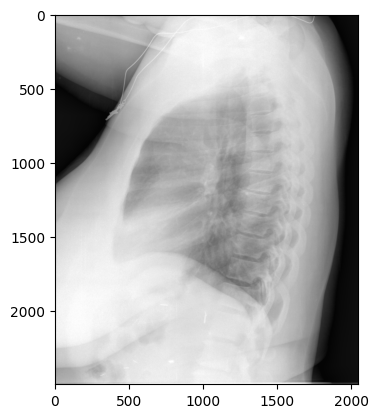

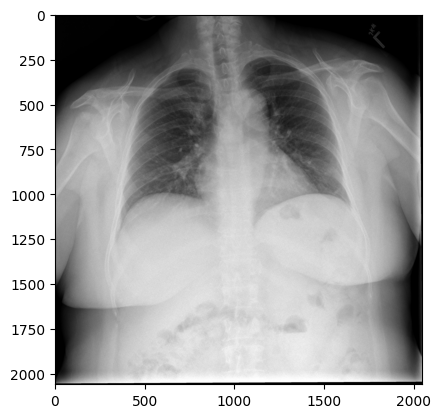

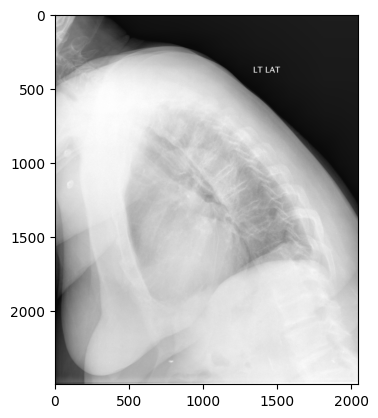

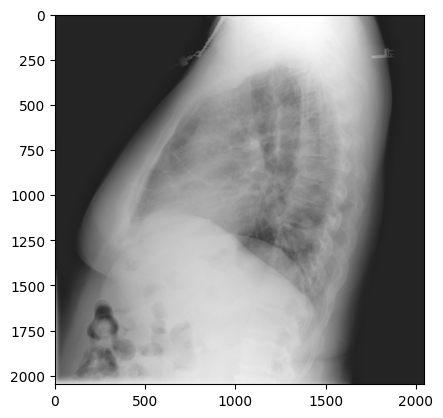

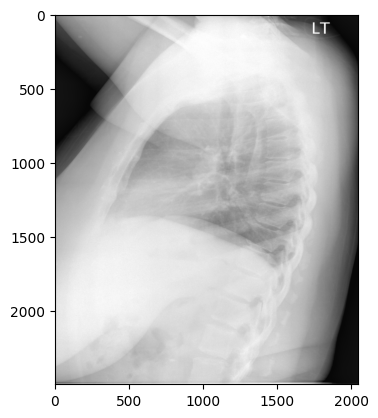

In [47]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

# Tokenization & Vocabulary Handling
First, we need helper functions for tokenizing captions and building a vocabulary.

In [48]:
# Helper function to tokenize captions (use an appropriate tokenizer based on your needs)
def tokenize_caption(caption):
    return caption.lower().split() if caption else []

# Helper function to convert captions to indices
def caption_to_indices(caption, vocab, max_len=30):
    caption_indices = [vocab.get(word, vocab['<unk>']) for word in caption]
    caption_indices = caption_indices[:max_len]  # Truncate to max_len
    caption_indices += [vocab['<pad>']] * (max_len - len(caption_indices))  # Pad if necessary
    return caption_indices


# Data Loading and Preprocessing
Now we need to load the dataset and preprocess the captions:

In [49]:
class IUXrayDataset(Dataset):
    def __init__(self, images_folder, projections_path, reports_path, vocab, transform=None, max_len=30):
        self.images_folder = images_folder
        self.projections_path = projections_path
        self.reports_path = reports_path
        self.vocab = vocab
        self.max_len = max_len
        self.transform = transform
        
        # Load the data
        projections = pd.read_csv(projections_path)
        reports = pd.read_csv(reports_path)

        # Check columns for debugging
        print("Projections columns:", projections.columns)
        print("Reports columns:", reports.columns)
        
        # Ensure both dataframes have the 'uid' column
        if 'uid' not in projections.columns or 'uid' not in reports.columns:
            raise ValueError("Both projections and reports must have a 'uid' column.")
        
        # Merge the datasets based on 'uid' to get image info and captions (using outer join)
        self.data = pd.merge(projections, reports, on='uid', how='outer')

        # Check if the merge resulted in any data
        if self.data.empty:
            raise ValueError("No data found after merging projections and reports.")
        
        # Reset index to avoid any indexing issues
        self.data.reset_index(drop=True, inplace=True)
        
        # Handle missing 'impression' values
        self.data['impression'] = self.data['impression'].fillna('<unk>')

        # Check for missing values and ensure the row has both 'filename' and 'impression'
        self.data = self.data.dropna(subset=['filename', 'impression'])

        # Take only 1000 images for training (to make the training faster)
        self.data = self.data.sample(n=1000, random_state=42)

        # Check the first few rows of the merged DataFrame
        print("Merged DataFrame head:", self.data.head())

        # Process the captions
        self.captions = []
        self.image_paths = []

        # Use `iterrows()` to avoid direct index access and handle rows more safely
        for _, row in self.data.iterrows():
            caption = row['impression']
            tokenized_caption = tokenize_caption(caption)
            self.captions.append(tokenized_caption)

            image_path = os.path.join(self.images_folder, row['filename'])
            self.image_paths.append(image_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        caption = self.captions[idx]
        
        # Convert caption to indices
        caption_indices = caption_to_indices(caption, self.vocab, max_len=self.max_len)
        
        # Load the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transformations (e.g., resizing, normalization)
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(caption_indices)

# Example usage (you should have your vocab ready):
vocab = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}  # Example vocab

# Initialize the dataset
dataset = IUXrayDataset(
    images_folder='/kaggle/input/chest-xrays-indiana-university/images/images_normalized',
    projections_path='/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv',
    reports_path='/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv',
    vocab=vocab
)

# Check dataset size and get a sample item
print("Dataset size:", len(dataset))
image, caption_indices = dataset[0]

print("Sample image shape:", image.shape)
print("Sample caption indices:", caption_indices)

Projections columns: Index(['uid', 'filename', 'projection'], dtype='object')
Reports columns: Index(['uid', 'MeSH', 'Problems', 'image', 'indication', 'comparison',
       'findings', 'impression'],
      dtype='object')
Merged DataFrame head:        uid                   filename projection  \
2276  1220  1220_IM-0148-3001.dcm.png    Frontal   
3497  1874  1874_IM-0565-1001.dcm.png    Frontal   
2124  1136  1136_IM-0092-2001.dcm.png    Lateral   
2890  1543  1543_IM-0353-1001.dcm.png    Frontal   
5570  3001  3001_IM-1387-3001.dcm.png    Frontal   

                                                   MeSH  \
2276  Lung/bilateral/hyperdistention;Lung, Hyperluce...   
3497  Pneumothorax/apex/right/small;Subcutaneous Emp...   
2124                                             normal   
2890                               Hernia, Hiatal/large   
5570                          Sulcus/posterior/obscured   

                                               Problems  \
2276  Lung;Lung, Hyperlucent

# Define the Custom Components  


**Visual Extractor (for feature extraction)**

In [50]:
class VisualExtractor(nn.Module):
    def __init__(self, args):
        super(VisualExtractor, self).__init__()
        # Example feature extraction layers
        self.resnet = torchvision.models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final fully connected layer
        self.num_features = 2048  # ResNet50 output features
        
    def forward(self, x):
        return self.resnet(x)


**ForeBackLearning (Foreground/Background Representation)**

In [51]:
class ForeBackLearning(nn.Module):
    def __init__(self, norm=None):
        super(ForeBackLearning, self).__init__()
        self.norm = norm

    def forward(self, patch_feats, cams, logits):
        fore_rep = patch_feats
        back_rep = patch_feats.mean(dim=1, keepdim=True)
        return fore_rep, back_rep, None

**CamAttnCon (Attention Mechanism)**

In [52]:
class CamAttnCon(nn.Module):
    def __init__(self, method='softmax', topk=5, layer_id=1, vis=False):
        super(CamAttnCon, self).__init__()
        self.method = method
        self.topk = topk
        self.layer_id = layer_id
        self.vis = vis

    def forward(self, fore_rep_encoded, target_embed, align_attns, targets):
        return align_attns, None, None

**Encoder-Decoder (LSTM-based)**

In [64]:
class EncoderDecoder(nn.Module):
    def __init__(self, vocab_size):
        super(EncoderDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 512)
        self.lstm = nn.LSTM(512, 512)
        self.fc = nn.Linear(512, vocab_size)

    def forward(self, global_features, patch_features, targets=None, mode='train'):
        if mode == 'train':
            embeddings = self.embedding(targets)
            global_features = global_features.view(global_features.size(0), -1)  # Flatten global features

            # Now concatenate
            features = torch.cat([global_features.unsqueeze(1), embeddings], dim=1)
            outputs, _ = self.lstm(features)
            outputs = self.fc(outputs)
            return outputs


In [65]:
print(global_features.size())  # Should be [batch_size, 2048]
print(embeddings.size())  # Should be [batch_size, sequence_length, 512]


NameError: name 'global_features' is not defined

# The Final R2GenModel

In [61]:
class R2GenModel(nn.Module):
    def __init__(self, args, tokenizer=None, logger=None, config=None):
        super(R2GenModel, self).__init__()

        # Accessing dictionary values correctly
        self.args = args
        self.addcls = args['addcls']  # Use the dictionary key to access values
        self.vis = args['vis']
        self.tokenizer = tokenizer
        self.visual_extractor = VisualExtractor(args)
        self.fbl = args['fbl']
        self.attn_cam = args['attn_cam']
        
        # If certain flags are set, initialize corresponding components
        if self.fbl:
            self.fore_back_learn = ForeBackLearning()
        if self.attn_cam:
            self.attn_cam_con = CamAttnCon(method=args['attn_method'], topk=args['topk'], layer_id=args['layer_id'], vis=args['vis'])

        self.encoder_decoder = EncoderDecoder(vocab_size=args['vocab_size'])

    def forward(self, images, targets=None, mode='train'):
        patch_feats = self.visual_extractor(images)
        
        if self.fbl:
            fore_rep, back_rep, _ = self.fore_back_learn(patch_feats, None, None)
            patch_feats = fore_rep
        
        outputs = self.encoder_decoder(patch_feats, patch_feats, targets=targets, mode=mode)
        
        return outputs


# Initialize DataLoader, Vocabulary, and Training

In [62]:
from torchvision import transforms
import torchvision

# Build vocabulary from all captions in the dataset
dataset = IUXrayDataset(images_folder, projections_path, reports_path, vocab=None)
captions = dataset.captions
vocab, idx_to_word = build_vocab(captions)

# Define the transformations (resizing and normalization)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize dataset and dataloaders
dataset = IUXrayDataset(images_folder, projections_path, reports_path, vocab=vocab, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model
args = {
    'vocab_size': len(vocab),  # Vocabulary size
    'addcls': True,
    'vis': False,
    'fbl': True,
    'attn_cam': True,
    'attn_method': 'softmax',
    'topk': 5,
    'layer_id': 1
}
model = R2GenModel(args)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, captions in train_loader:
            optimizer.zero_grad()
            outputs = model(images, targets=captions, mode='train')
            loss = criterion(outputs.view(-1, len(vocab)), captions.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

# Start training
train(model, train_loader, criterion, optimizer)


Projections columns: Index(['uid', 'filename', 'projection'], dtype='object')
Reports columns: Index(['uid', 'MeSH', 'Problems', 'image', 'indication', 'comparison',
       'findings', 'impression'],
      dtype='object')
Merged DataFrame head:        uid                   filename projection  \
2276  1220  1220_IM-0148-3001.dcm.png    Frontal   
3497  1874  1874_IM-0565-1001.dcm.png    Frontal   
2124  1136  1136_IM-0092-2001.dcm.png    Lateral   
2890  1543  1543_IM-0353-1001.dcm.png    Frontal   
5570  3001  3001_IM-1387-3001.dcm.png    Frontal   

                                                   MeSH  \
2276  Lung/bilateral/hyperdistention;Lung, Hyperluce...   
3497  Pneumothorax/apex/right/small;Subcutaneous Emp...   
2124                                             normal   
2890                               Hernia, Hiatal/large   
5570                          Sulcus/posterior/obscured   

                                               Problems  \
2276  Lung;Lung, Hyperlucent

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 2048 but got size 512 for tensor number 1 in the list.